# Fatores inibidores do uso de celulares para internet
## SEPEP/Assessoria Técnica

### Sobre o Estudo
Neste notebook, analisamos os fatores inibidores do acesso à internet por meio de celulares no Estado de São Paulo.

O estudo se vale dos microdados da Pesquisa TIC Domicílios (https://cetic.br/pesquisa/domicilios/) realizada pelo  Centro Regional de Estudos para o Desenvolvimento da Sociedade da Informação, departamento de pesquisa do Núcleo de Informação e Coordenação do Ponto BR (NIC.br), ligado ao Comitê Gestor da Internet do Brasil (CGI.br).

Trata-se de pesquisa anual sobre os hábitos de utilização de tecnologia e internet dos brasileiros, realizada de forma amostral com significância a nível de Estado.

Os dados utilizados são os mais atualizados, e correspondem ao ano de 2022.

### Principais resultados

Após análise e tratamento dos dados, verificamos que:
* No estado de São Paulo, aprox. 30% da população ou não possui acesso a um celular ou, apesar de ter acesso a um celular, não o utiliza para acessar a internet.

Com objetivo de analisar os fatores associados à não-utilização do celular, implementamos uma Regressão Logística Múltipla.

Com acurácia de aprox. 80%, nosso modelo pôde identificar que:
* A condição de idoso;
* A baixa escolaridade (analfabeto ou acesso apenas ao ensino infantil);
* A baixa renda (sem renda ou menos que um salário mínimo);
* E ser negro

São fatores estatisticamente associados à uma menor propensão ao uso do celular para acesso à internet no Estado de São Paulo.


A seguir, carregamos as dependências utilizadas no estudo.

In [1]:
import pandas as pd
import requests
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
sns.set()

### Download dos dados

Com o objetivo de tornar este estudo plenamente replicável, abaixo desenvolvemos uma função que faz o download dos microdados a nível individual da TIC BR de 2022.

In [3]:
URL_MICRODADOS = 'https://cetic.br/media/microdados/694/tic_domicilios_2022_individuos_base_de_microdados_v1.0.csv'
FOLDER_DADOS = 'data'

def download_dados(fname:str, url:str=URL_MICRODADOS, folder:str=FOLDER_DADOS)->str:
    
    fpath = os.path.join(folder, fname)
    
    if os.path.exists(fpath):
        return fpath
    
    #cria folder se nao existir
    if not os.path.exists(folder):
        os.mkdir(folder)
        
    with requests.get(url) as r:
        data = r.text
        
    with open(fpath, 'w') as f:
        f.write(data)
    
    return fpath

In [4]:
fname = download_dados('microdados_ticbr_individuos.csv')

In [5]:
fname

'data/microdados_ticbr_individuos.csv'

In [6]:
df = pd.read_csv(fname, sep=';')

In [7]:
df.head()

,QUEST,ID_DOMICILIO,ID_MORADOR,SEXO,IDADE,FAIXA_ETARIA,GRAU_INSTRUCAO,PEA,RENDA_PESSOAL,RACA,...,rep191,rep192,rep193,rep194,rep195,rep196,rep197,rep198,rep199,rep200
0,168775373,5072,2,2,24,2,10,1,1,1,...,2,1,1,1,1,1,0,0,2,2
1,168775374,5073,1,2,58,5,9,5,9,3,...,2,1,1,1,1,1,0,0,2,2
2,168775378,5077,2,2,64,6,10,5,1,3,...,2,1,1,1,1,1,0,0,2,2
3,168775379,5079,1,1,48,5,6,1,1,3,...,2,1,1,1,1,1,0,0,2,2
4,168775380,5080,5,2,55,5,1,1,1,2,...,2,1,1,1,1,1,0,0,2,2


### Limpeza dos dados

A seguir, realizamos a limpeza dos dados.

Eles são filtrados para a Região Sudeste, onde se situa o município de São Paulo.

In [8]:
df.columns[:12]

Index(['QUEST', 'ID_DOMICILIO', 'ID_MORADOR', 'SEXO', 'IDADE', 'FAIXA_ETARIA',
       'GRAU_INSTRUCAO', 'PEA', 'RENDA_PESSOAL', 'RACA', 'C1', 'C2_A'],
      dtype='object')

Filtrar para a região sudeste (infelizmente não tem amostragem a nível de município)

In [9]:
regiao_sudeste = 1

filtro_regiao_sudeste = df['COD_REGIAO_2']==regiao_sudeste

df = df[filtro_regiao_sudeste].reset_index(drop=True)

In [10]:
len(df)

2705

Nas células a seguir, com base no dicionário de variáveis disponibilizados pela CETIC, traduzimos os códigos tabulados na base de dados para seus resultados.

A questão J3 questiona se o indivíduo utilizou o celular para acesso à internet nos últimos 3 meses.

In [11]:
mapper_respostas = {
    0:"Não",
    1:"Sim",
    97:"Não sabe",
    98:"Não respondeu",
    99:"Não se aplica"
}

In [12]:
usou_celular_para_internet = 'J3'


In [13]:
df['usou_celular_para_internet'] = df['J3'].map(mapper_respostas)

In [14]:
df['usou_celular_para_internet'].value_counts(normalize=True)

Sim              0.720518
Não se aplica    0.141220
Não              0.137153
Não sabe         0.001109
Name: usou_celular_para_internet, dtype: float64

A questão J1 questiona se o indivíduo utilizou um celular nos últimos 3 meses. Como verificamos abaixo, caso ele não tenha utilizado um celular nos últimos 3 meses, sua resposta para a questão J3 (se usou o celular para acesso à internet) é "Não se aplica", o que é consistente.

In [15]:
df['usou_celular_3_meses'] = df['J1'].map(mapper_respostas)

Veja abaixo que os dados são consistentes:

In [16]:
df[df['usou_celular_para_internet']=='Não se aplica']['usou_celular_3_meses'].unique()

array(['Não'], dtype=object)

Com isso, reajustamos a resposta "Não se aplica" para a questão J3 para "Não tem acesso a celular".

In [17]:
df['usou_celular_para_internet'] = df['usou_celular_para_internet'].apply(lambda x: 'Não tem acesso a celular' if x=='Não se aplica' else x)

In [18]:
df['usou_celular_para_internet'].value_counts(normalize=True)

Sim                         0.720518
Não tem acesso a celular    0.141220
Não                         0.137153
Não sabe                    0.001109
Name: usou_celular_para_internet, dtype: float64

Todos os que responderam que não usaram celular para internet, usaram algum celular (ou seja tem acesso) nos últimos 3 meses

In [19]:
df[df['usou_celular_para_internet']=='Não']['usou_celular_3_meses'].unique()

array(['Sim'], dtype=object)

In [20]:
df[df['usou_celular_para_internet']=='Não sabe']['usou_celular_3_meses'].unique()

array(['Sim'], dtype=object)

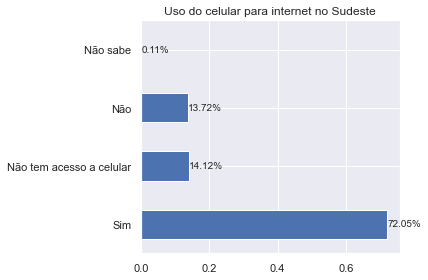

In [21]:
ax = df['usou_celular_para_internet'].value_counts(normalize=True).plot.barh(title='Uso do celular para internet no Sudeste')


ax.bar_label(ax.containers[0], fmt='{:.2%}')
plt.tight_layout()
fig = ax.get_figure()
fig.savefig('grafico_uso_celular.jpeg')


### Seleção de variáveis

A seguir, selecionamos as variáveis explicativas de interesse em nosso estudo e mapeamos seus códigos 

Vamos usar a variável renda

In [22]:
mapper_renda = {
    1:"Até R$ 1.302,00",
    2:"De R$ 1.302,01 até R$ 2.604,00",
    3:"De R$ 2.604,01 até R$ 3.906,00",
    4:"De R$ 3.906,01 até R$ 6.510,00",
    5:"De R$ 6.510,01 até R$ 13.020,00",
    6:"De R$ 13.020,01 até R$ 26.040,00",
    7:"De R$ 26.040,01 até R$ 39.060,00",
    8:"Mais de R$ 39.060,00",
    9:"Não tem renda",
    97:"Não sabe",
    98:"Não respondeu",
}

In [23]:
df['renda_pessoal']  = df['RENDA_PESSOAL'].apply(lambda x: mapper_renda[x])

E raca

In [24]:
df['RACA'].unique()

array([ 1,  3,  2,  4,  5, 98])

In [25]:
mapper_raca = {1:"Branca",
2:"Preta",
3:"Parda",
4:"Amarela",
5:"Indígena",
98:"Não respondesu"}

In [26]:
df['raca'] = df['RACA'].map(mapper_raca)

E grau de instrucao

In [27]:
mapper_instrucao = {
1:"Analfabeto/Educação Infantil",
2:"Fundamental",
3:"Médio",
4:"Superior",
}

In [28]:
df['grau_instrucao'] = df['GRAU_INSTRUCAO_2'].map(mapper_instrucao)

E condição de atividade (empregado ou nao)

In [29]:
mapper_atividade = {
1:"Na força de trabalho",
2:"Fora da força de trabalho",
}

In [30]:
df['condicao_atividade'] = df['PEA_2'].map(mapper_atividade)

E faixa etária

In [31]:
mapper_faixa_etaria = {1:"De 10 a 15 anos",
                    2:"De 16 a 24 anos",
                    3:"De 25 a 34 anos",
                    4:"De 35 a 44 anos",
                    5:"De 45 a 59 anos",
                    6:"De 60 anos ou mais"}

In [32]:
df['faixa_etaria'] = df['FAIXA_ETARIA'].map(mapper_faixa_etaria)

E sexo

In [33]:
mapper_sexo = {1: 'masculino', 2 : 'feminino'}

df['sexo'] = df['SEXO'].map(mapper_sexo)

Vamos verificar se cada registro identifica uma pessoa única dentro de um município

In [34]:
(df['ID_DOMICILIO'].astype(str) + '.' + df['ID_MORADOR'].astype(str)).duplicated().any()==False

True

In [35]:
(df['ID_DOMICILIO'].astype(str) + '.' + df['ID_MORADOR'].astype(str)).nunique()==len(df)

True

Com isso, podemos filtrar o dataframe para nossos dados de interesse.

In [36]:
colunas_interesse = [
    'sexo',
    'raca', 
    'faixa_etaria',
    'grau_instrucao',
    'renda_pessoal', 
    'condicao_atividade',  
    'usou_celular_para_internet'
    
]

In [37]:
df = df[colunas_interesse]

In [38]:
df.columns

Index(['sexo', 'raca', 'faixa_etaria', 'grau_instrucao', 'renda_pessoal',
       'condicao_atividade', 'usou_celular_para_internet'],
      dtype='object')

A ultima coisa que precisamos fazer é filtrar as crianças

In [39]:
df['faixa_etaria'].unique()

array(['De 35 a 44 anos', 'De 45 a 59 anos', 'De 16 a 24 anos',
       'De 25 a 34 anos', 'De 60 anos ou mais', 'De 10 a 15 anos'],
      dtype=object)

In [40]:
df = df[df['faixa_etaria']!='De 10 a 15 anos'].reset_index(drop=True)

In [41]:
df['faixa_etaria'].unique()

array(['De 35 a 44 anos', 'De 45 a 59 anos', 'De 16 a 24 anos',
       'De 25 a 34 anos', 'De 60 anos ou mais'], dtype=object)

### Construção das features

Coma base em nossas variáveis de interesse, construímos as features que integrarão o modelo e as formatamos como dummies.

In [42]:
df_final = pd.DataFrame()

Primeiro nossa variavel y

In [43]:
df['usou_celular_para_internet'].unique()

array(['Não', 'Sim', 'Não tem acesso a celular', 'Não sabe'], dtype=object)

Temos que filtrar aqueles que responderam 'Não sabe', pois pode dificultar o modelo.

In [44]:
df = df[df['usou_celular_para_internet']!='Não sabe'].reset_index(drop=True)

In [45]:
len(df)

2595

E vamos binarizar: o sucesso é "Sim", usou o celular, independentemente de ter acesso a um ou não.

In [46]:
df_final['usou_celular_para_internet'] = (df['usou_celular_para_internet']=='Sim').astype(int)

Vamos identificar os idosos

In [47]:
df_final['idoso'] = (df['faixa_etaria']=='De 60 anos ou mais').astype(int)

Identificar desempregados:

Que sao os que estao fora da força de trabalho e nao sao idosos (crianças já filtramos)

In [48]:
df['condicao_atividade'].unique()

array(['Na força de trabalho', 'Fora da força de trabalho'], dtype=object)

In [49]:
df_final['desempregado'] = ((df['condicao_atividade']=='Fora da força de trabalho')
                            &(~df_final['idoso'])).astype(int)

In [50]:
df_final['desempregado'].unique()

array([0, 1])

Negros

In [51]:
df['raca'].unique()

array(['Branca', 'Parda', 'Preta', 'Amarela', 'Indígena',
       'Não respondesu'], dtype=object)

In [52]:
df_final['negro'] = (df['raca'].isin(['Preta', 'Parda'])).astype(int)

In [53]:
df_final['negro'].unique()

array([0, 1])

Mulheres

In [54]:
df['sexo'].unique()

array(['masculino', 'feminino'], dtype=object)

In [55]:
df_final['mulher'] = (df['sexo']=='feminino').astype(int)

In [56]:
df_final['mulher'].unique()

array([0, 1])

Sem ensino básico

In [57]:
df['grau_instrucao'].unique()

array(['Analfabeto/Educação Infantil', 'Médio', 'Fundamental', 'Superior'],
      dtype=object)

In [58]:
df_final['sem_ensino_basico'] = (df['grau_instrucao']=='Analfabeto/Educação Infantil').astype(int)

Renda até 1sm

In [59]:
df['renda_pessoal'].unique()

array(['Até R$ 1.302,00', 'De R$ 1.302,01 até R$ 2.604,00',
       'De R$ 2.604,01 até R$ 3.906,00', 'De R$ 3.906,01 até R$ 6.510,00',
       'Não tem renda', 'Não respondeu',
       'De R$ 6.510,01 até R$ 13.020,00', 'Não sabe',
       'De R$ 13.020,01 até R$ 26.040,00',
       'De R$ 26.040,01 até R$ 39.060,00', 'Mais de R$ 39.060,00'],
      dtype=object)

In [60]:
df_final['renda_até_1sm'] = (df['renda_pessoal'].isin(['Até R$ 1.302,00', 'Não tem renda'])).astype(int)

In [61]:
df_final

,usou_celular_para_internet,idoso,desempregado,negro,mulher,sem_ensino_basico,renda_até_1sm
0,0,0,0,0,0,1,1
1,1,0,0,1,1,1,0
2,1,0,1,1,1,0,1
3,1,0,0,1,1,0,1
4,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...
2590,0,0,1,1,1,0,0
2591,1,0,0,1,1,0,1
2592,1,0,0,1,0,0,0
2593,1,0,0,1,0,0,0


### Modelagem

Como nossa variável y é binária, desenvolveremos uma regressão logística.

Nas células a seguir, treinamos o modelo e computamos sua acurácia.

In [62]:
df_final['usou_celular_para_internet'].unique()

array([0, 1])

In [63]:
df_final['const'] = 1

In [64]:
import statsmodels.api as sm

In [65]:
y = df_final['usou_celular_para_internet']

In [66]:
x = df_final.drop('usou_celular_para_internet', axis=1)

#### correlações

Abaixo, verificamos que apesar de haver correlações entre as variáveis escolhidas para o modelo, ela não chega a ser tão alta.

<Axes: >

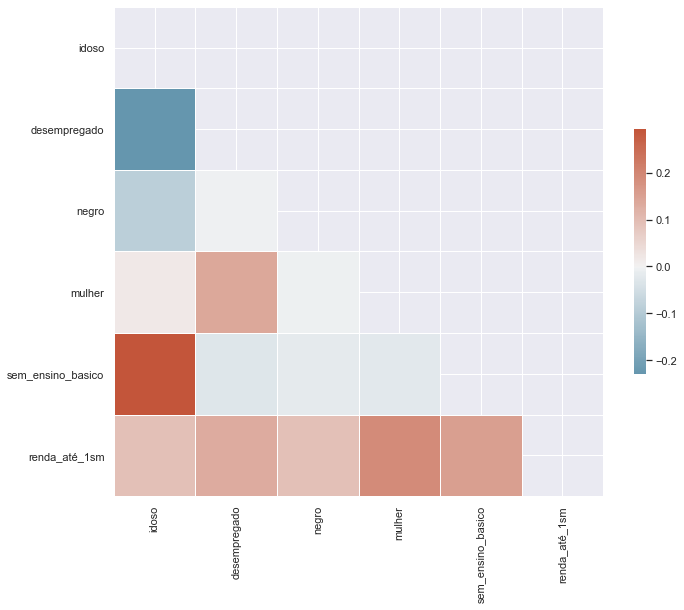

In [67]:

# Compute the correlation matrix
corr = x.drop('const', axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [68]:
corr

,idoso,desempregado,negro,mulher,sem_ensino_basico,renda_até_1sm
idoso,1.000000,-0.228584,-0.088048,0.017532,0.292575,0.092783
desempregado,-0.228584,1.000000,-0.004481,0.137808,-0.029171,0.130604
negro,-0.088048,-0.004481,1.000000,-0.005886,-0.019388,0.091775
mulher,0.017532,0.137808,-0.005886,1.000000,-0.023927,0.189446
sem_ensino_basico,0.292575,-0.029171,-0.019388,-0.023927,1.000000,0.153704
renda_até_1sm,0.092783,0.130604,0.091775,0.189446,0.153704,1.000000


Treinamos o modelo abaixo

In [69]:
log_reg = sm.Logit(y, x).fit()

Optimization terminated successfully.
         Current function value: 0.442129
         Iterations 6


E inspecionamos os resultados.

In [70]:
print(log_reg.summary())

                               Logit Regression Results                               
Dep. Variable:     usou_celular_para_internet   No. Observations:                 2595
Model:                                  Logit   Df Residuals:                     2588
Method:                                   MLE   Df Model:                            6
Date:                        Mon, 21 Aug 2023   Pseudo R-squ.:                  0.2634
Time:                                18:59:34   Log-Likelihood:                -1147.3
converged:                               True   LL-Null:                       -1557.6
Covariance Type:                    nonrobust   LLR p-value:                5.671e-174
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
idoso                -2.3350      0.114    -20.557      0.000      -2.558      -2.112
desempregado         -0.4074      0.190     -2

### Acurácia do modelo

A seguir, verificamos a acurácia do modelo na base de treino.

In [71]:
from sklearn.metrics import accuracy_score

In [72]:
pred = log_reg.predict(x)

In [73]:
y_pred = (pred>0.5).astype(int)

In [74]:
y_pred.mean()

0.7202312138728324

In [75]:
y.mean()

0.7121387283236994

Temos um score de 80% aproximadamente.

In [76]:
accuracy_score(y, y_pred)

0.7961464354527938

### Interpretação dos parâmetros

Abaixo, exponenciamos os parâmetros da regressão logística para auxiliar na interpretação.

Também implementamos uma regressão linear múltipla, que permite a comparação dos tamanhos de efeito das variáveis.

In [77]:
import math

In [78]:
log_reg.params.apply(math.exp)

idoso                 0.096811
desempregado          0.665363
negro                 0.835365
mulher                1.742591
sem_ensino_basico     0.236138
renda_até_1sm         0.495091
const                10.229591
dtype: float64

In [79]:
lin_reg = sm.OLS(y, x).fit()

In [80]:
print(lin_reg.summary())

                                OLS Regression Results                                
Dep. Variable:     usou_celular_para_internet   R-squared:                       0.313
Model:                                    OLS   Adj. R-squared:                  0.311
Method:                         Least Squares   F-statistic:                     196.1
Date:                        Mon, 21 Aug 2023   Prob (F-statistic):          2.08e-206
Time:                                18:59:35   Log-Likelihood:                -1139.7
No. Observations:                        2595   AIC:                             2293.
Df Residuals:                            2588   BIC:                             2334.
Df Model:                                   6                                         
Covariance Type:                    nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

In [81]:
lin_reg.params

idoso               -0.437140
desempregado        -0.047127
negro               -0.025644
mulher               0.080197
sem_ensino_basico   -0.273253
renda_até_1sm       -0.101128
const                0.915121
dtype: float64

In [82]:
df_params = pd.DataFrame([log_reg.params.apply(math.exp), lin_reg.params]).T
df_params.columns = ['Regressão Logística', 'Regressão Linear']

In [83]:
df_params.sort_values(by='Regressão Linear')

,Regressão Logística,Regressão Linear
idoso,0.096811,-0.437140
sem_ensino_basico,0.236138,-0.273253
renda_até_1sm,0.495091,-0.101128
desempregado,0.665363,-0.047127
negro,0.835365,-0.025644
mulher,1.742591,0.080197
const,10.229591,0.915121
